In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tfs

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import gc
from skimage.color import rgb2lab, lab2rgb

from torchsummary import summary
from tqdm import tqdm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


In [ ]:
videos_path = '/content/drive/MyDrive/Spring 2022/11785 Deep Learning TA/Project/Sample Dataset (DAVIS and Videvo)/DAVIS/'
videos_root = os.listdir(videos_path)

context = 3

x = []

for i, vid in enumerate(videos_root):
    frames = sorted(os.listdir(videos_path + vid))
    frames = [vid + '/' + frame for frame in frames]
    x.extend([(frames[j:j+context], frames[(2*j+context)//2]) for j in range(0, len(frames) + 1 - context)])

In [ ]:
from torchvision.transforms.transforms import ToPILImage
videos_path = '/content/drive/MyDrive/Spring 2022/11785 Deep Learning TA/Project/Sample Dataset (DAVIS and Videvo)/DAVIS/'
videos_root = os.listdir(videos_path)

context = 3
resize_size = 224

transforms = tfs.Compose([tfs.ToTensor()])

data = []

for i, vid in enumerate(videos_root):
    frames = sorted(os.listdir(videos_path + vid))
    frames = [vid + '/' + frame for frame in frames]
    print("Loading video ", i+1)
    for j in tqdm(range(0, len(frames) + 1 - context)):
        x = []
        for k in range(context):
            img = rgb2lab(plt.imread(videos_path + frames[j+k]))
            img = cv2.resize(img, (resize_size, resize_size))
            img = transforms(img)
            x.append(img[0, :, :])

        x = torch.stack(x, dim= 0)
        img = cv2.resize(rgb2lab(plt.imread(videos_path + frames[(2*j+k)//2])), (resize_size, resize_size))
        y = transforms(img[:,:,1:3])

        data.append((x, y))

In [ ]:
ylab = rgb2lab(y)
print(ylab.shape)
plt.imshow(ylab[:, :, 0])

In [ ]:
# Dataset class videos path is the folder containing folders of video frames

class VCdataset(torch.utils.data.Dataset):
    
    def __init__(self, videos_path, resize_size, context):

        self.videos_path = videos_path
        self.resize_size= resize_size
        videos_root = os.listdir(videos_path)
        data = []

        for i, vid in enumerate(videos_root):
            frames = sorted(os.listdir(videos_path + vid))
            frames = [vid + '/' + frame for frame in frames]
            data.extend([(frames[j:j+context], frames[(2*j+context)//2]) for j in range(0, len(frames) + 1 - context)])
        
        self.data = data
        self.transforms = tfs.Compose([tfs.ToTensor()])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):

        x, y = self.data[ind]
        X = []

        for img_path in x:
            img = rgb2lab(plt.imread(videos_path + img_path))
            img = cv2.resize(img, (self.resize_size, self.resize_size))
            img = self.transforms(img)
            X.append(img[0, :, :])

        X = torch.stack(X, dim= 0)
        yimg = cv2.resize(rgb2lab(plt.imread(self.videos_path + y)), (self.resize_size, self.resize_size))
        Y = self.transforms(yimg[:,:,1:3])

        return X, Y

In [ ]:
videos_path = '/content/drive/MyDrive/Spring 2022/11785 Deep Learning TA/Project/Sample Dataset (DAVIS and Videvo)/DAVIS/'

batch_size= 2

train_data = VCdataset(videos_path, resize_size= 256, context= 3)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle= True)
print("No: Image sets: ", train_data.__len__())
print("Batch size: ", batch_size)
print("Number of batches: ", len(train_loader))

No: Image sets:  243
Batch size:  2
Number of batches:  122


In [ ]:
for data in train_loader:
    x, y = data
    print(x.shape, y.shape)
    break

torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 256, 256])


In [ ]:
x, y = train_data[0]
print(x.shape, y.shape)

torch.Size([3, 256, 256]) torch.Size([2, 256, 256])


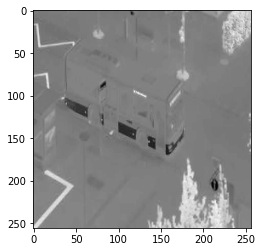

In [ ]:
plt.imshow(y[1, :, :], cmap='gray')

In [ ]:
class ContextModel(nn.Module):

    def __init__(self, context):
        super(ContextModel, self).__init__()
        
        self.context = context
        self.att_conv = nn.ModuleList()

        for i in range(context): # init conv weight map blocks for frames other than middle one
            
            layer = None if i == context//2 else nn.Sequential(
                nn.Conv2d(2, 64, kernel_size= 3, padding= 1, bias= True),
                nn.ReLU(True),
                nn.Conv2d(64, 1, kernel_size= 1, bias= True),
                nn.Sigmoid()
            )

            self.att_conv.append(layer)


    def forward(self, x):
        xt = x[:, self.context//2, :, :]

        for i in range(self.context):
            if i != self.context//2:
                img = torch.stack([xt, x[:, i]], dim= 1)
                x[:, i] *= self.att_conv[i](img).squeeze(1)

        return x
        
cm = ContextModel(context= 5).to(device)
print(cm)
summary(cm, (5, 224, 224))

ContextModel(
  (att_conv): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (3): Sigmoid()
    )
    (1): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (3): Sigmoid()
    )
    (2): None
    (3): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (3): Sigmoid()
    )
    (4): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (3): Sigmoid()
    )
  )
)
----------------------------------------------------------------
        Layer (type